# Programming Exercise 3: Multi-class Classification and Neural Networks

In this exercise, you will implement one-vs-all logistic regression and neural networks to recognize hand-written digits.

## 1. Multi-class Classification

For this exercise, you will use logistic regression and neural networks to recognize handwritten digits (from 0 to 9). Automated handwritten digit recognition is widely used today - from recognizing zip codes (postal codes)
on mail envelopes to recognizing amounts written on bank checks. This exercise will show you how the methods you’ve learned can be used for this classification task.

In the first part of the exercise, you will extend your previous implementation of logistic regression and apply it to one-vs-all classification.

### 1.1. Dataset

You are given a data set in `ex3data1.mat` that contains 5000 training examples of handwritten digits. The `.mat` format means that that the data has been saved in a native Octave/MATLAB matrix format, instead of a text (ASCII) format like a csv-file.

In [1]:
# Import function to load .mat files
from scipy.io import loadmat

In [2]:
# Load data
data = loadmat('ex3data1.mat')
X = data['X']
y = data['y']

There are 5000 training examples in `ex3data1.mat`, where each training example is a 20 pixel by 20 pixel grayscale image of the digit. Each pixel is represented by a floating point number indicating the grayscale intensity at that location. The 20 by 20 grid of pixels is “unrolled” into a 400-dimensional vector. Each of these training examples becomes a single row in our data matrix X. This gives us a 5000 by 400 matrix X where every row is a training example for a handwritten digit image.

In [3]:
# Check the shapes of X and y
X.shape, y.shape

((5000, 400), (5000, 1))

### 1.2. Visualizing the data

You will begin by visualizing a subset of the training set.

In [4]:
# Import libraries
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

In [5]:
# Select some random training data points
n = 50
X_vis = X[np.random.randint(X.shape[0], size=n)]

In [24]:
def display_numbers(X_vis):
    # Compute rows, cols
    if X_vis.ndim == 1:
        m, n = 1, len(X_vis)
    else:
        m, n = X_vis.shape
    example_width = np.round(np.sqrt(n)).astype(int)
    example_height = (n / example_width).astype(int)
    
    # Compute number of items to display
    display_rows = np.floor(np.sqrt(m)).astype(int)
    display_cols = np.ceil(m / display_rows).astype(int)
    
    # Between images padding
    pad = 1
    # Setup blank display
    display_array = - np.ones((pad + display_rows * (example_height + pad),
                               pad + display_cols * (example_width + pad)))
    
    # Copy each example into a patch on the display array
    if m == 1:
        max_val = np.max(np.abs(X_vis))
        display_array = np.reshape(X_vis, (example_height, example_width)) / max_val
    else:
        curr_ex = 0;
        for j in range(display_rows):
            for i in range(display_cols):
                if curr_ex >= m:
                    break
                # Copy the patch

                # Get the max value of the patch
                max_val = np.max(np.abs(X_vis[curr_ex, :]))
                rows = pad + j * (example_height + pad) + np.arange(example_height)
                cols = pad + i * (example_width + pad) + np.arange(example_width)
                display_array[np.ix_(rows, cols)] = np.reshape(X_vis[curr_ex, :], (example_height, example_width)) / max_val
                curr_ex = curr_ex + 1

            if curr_ex >= m:
                break
    
    # Display image
    plt.imshow(display_array.T)
    plt.show()

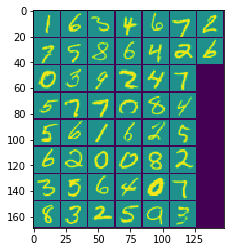

In [7]:
display_numbers(X_vis)

### 1.3. Vectorizing Logistic Regression

Recall that the regularized cost function in logistic regression is:

$$
J(\boldsymbol{\theta}) = -\frac{1}{m} \left[y^T \log\left(\frac{1}{1 + e^{-\boldsymbol{X}\boldsymbol{\theta}}}\right) + (1- y)^T \log\left(\frac{e^{-\boldsymbol{X}\boldsymbol{\theta}}}{1 + e^{-\boldsymbol{X}\boldsymbol{\theta}}}\right) + \frac{\lambda}{2}\left\lvert\left\lvert \boldsymbol{A}\boldsymbol{\theta}\right\rvert\right\rvert^2\right],
$$

and the gradient of this cost is

$$
\frac{\partial}{\partial \boldsymbol{\theta}} J(\boldsymbol{\theta}) = \frac{1}{m} \boldsymbol{X}^T \left[\left(\frac{1}{1 + e^{-\boldsymbol{X}\boldsymbol{\theta}}}\right) - y\right] + \frac{\lambda}{m}\boldsymbol{A}\boldsymbol{\theta}.
$$

In [8]:
# Sigmoid function
def sigmoid(z):
    return 1 / (1 + np.exp(-z))

In [9]:
X = np.concatenate((np.ones((len(y), 1)), X), axis=1)
# Cost function
def J(theta, X, y):
    m = len(y)
    h = sigmoid(X.dot(theta))
    return -(y.dot(np.log(h)) + (1 - y).dot(np.log(1 - h))) / m
# Gradient
def gradJ(theta, X, y):
    m = len(y)
    h = sigmoid(X.dot(theta))
    return X.T.dot(h - y) / m

In [10]:
# Cost function
def J_reg(theta, X, y, l):
    m, np1 = X.shape
    A = np.block([[np.zeros((1, 1)), np.zeros((1, np1 - 1))],
                  [np.zeros((np1 - 1, 1)), np.eye(np1 - 1)]])
    return J(theta, X, y) + l * np.linalg.norm(A.dot(theta))**2 / (2 * m)
# Gradient
def gradJ_reg(theta, X, y, l):
    m, np1 = X.shape
    A = np.block([[np.zeros((1, 1)), np.zeros((1, np1 - 1))],
                  [np.zeros((np1 - 1, 1)), np.eye(np1 - 1)]])
    return gradJ(theta, X, y) + l * A.dot(theta) / m

### 1.4. One-vs-all classification

In this part of the exercise, you will implement one-vs-all classification by training multiple regularized logistic regression classifiers, one for each of the $K$ classes in our dataset.

In [11]:
# Numerical optimizer
from scipy.optimize import minimize

In [12]:
# Number of different classes
K = 10

In [13]:
# One vs. all training
all_theta = np.zeros((K, X.shape[1]))

for c in range(1, K + 1):
    # Set Initial theta
    initial_theta = np.zeros(X.shape[1])

    # Run numerical optimizer
    solution = minimize(fun=J_reg,
                        jac=gradJ_reg,
                        x0=initial_theta,
                        args=(X, (y.T[0] == c) * 1, 0.1))
    print(solution.fun)
    
    # Get the result
    all_theta[c - 1, :] = solution.x

0.013128373669473736
0.050810113904853675
0.057611641193562914
0.033074850125163646
0.054465643580802726
0.018264576972100807
0.030653180391400543
0.07845733652701993
0.07119337754642008
0.008583336445757653


In [14]:
# Predictions
prob = sigmoid(X.dot(all_theta.T))
p = prob.argmax(axis=1) + 1

In [15]:
# Accuracy on the training set
(p == y.T[0]).mean()

0.9648

## 2. Neural Networks

In the previous part of this exercise, you implemented multi-class logistic re-
gression to recognize handwritten digits. However, logistic regression cannot
form more complex hypotheses as it is only a linear classifier.

In this part of the exercise, you will implement a neural network to recognize handwritten digits using the same training set as before. The neural network will be able to represent complex models that form non-linear hypotheses.

For this exercise, you will be using parameters from a neural network that has been already trained.

The neural network has 3 layers – an input layer, a hidden layer and an output layer. Recall that our inputs are pixel values of digit images. Since the images are of size 20×20, this gives us 400 input layer units (excluding the extra bias unit which always outputs +1). As before, the training data will be loaded into the variables X and y.

You have been provided with a set of network parameters ($\Theta^{(1)}$, $\Theta^{(2)}$) already trained. These are stored in `ex3weights.mat` into Theta1 and Theta2. The parameters have dimensions that are sized for a neural network with 25 units in the second layer and 10 output units (corresponding to the 10 digit classes).

In [16]:
# Load data
data = loadmat('ex3weights.mat')
Theta1 = data['Theta1']
Theta2 = data['Theta2']

In [17]:
# Load data
data = loadmat('ex3data1.mat')
X = data['X']
y = data['y']

In [18]:
# Check the shapes of Theta1 and Theta2
Theta1.shape, Theta2.shape

((25, 401), (10, 26))

Now you will implement feedforward propagation for the neural network.

You should implement the feedforward computation that computes $h_{\theta}(x^{(i)})$ for every example $i$ and returns the associated predictions. Similar to the one-vs-all classification strategy, the prediction from the neural network will be the label that has the largest output $h_{\theta}(x^{(i)})_k$.

In [19]:
def predict(Theta1, Theta2, X):
    m = X.shape[0]
    # a1
    A1 = X.T
    # a2
    Z2 = Theta1.dot(np.block([[np.ones((1, m))],
                              [A1]            ]))
    A2 = sigmoid(Z2)
    # a3
    Z3 = Theta2.dot(np.block([[np.ones((1, m))],
                              [A2]            ]))
    A3 = sigmoid(Z3)
    
    # Predictions
    p = A3.argmax(axis=0) + 1
    
    return p

In [20]:
p = predict(Theta1, Theta2, X)

In [21]:
# Accuracy on the training set
(p == y.T[0]).mean()

0.9752


Displaying Example Image



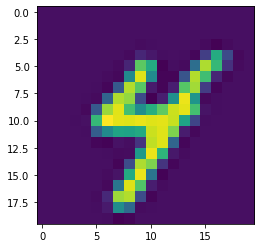


Neural Network Prediction: [4]

Paused - press enter to continue, q to exit:

Displaying Example Image



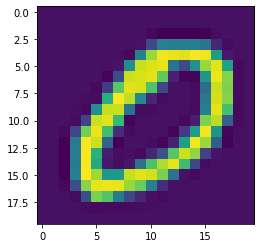


Neural Network Prediction: [10]

Paused - press enter to continue, q to exit:

Displaying Example Image



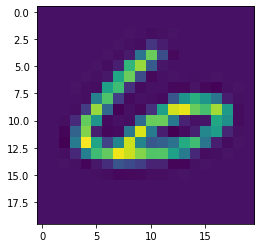


Neural Network Prediction: [6]

Paused - press enter to continue, q to exit:

Displaying Example Image



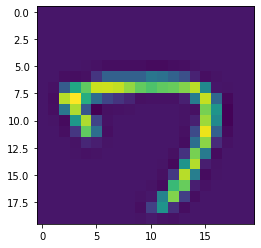


Neural Network Prediction: [7]

Paused - press enter to continue, q to exit:

Displaying Example Image



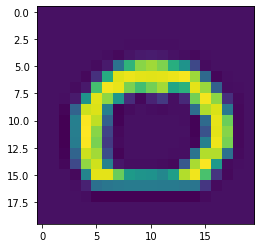


Neural Network Prediction: [10]

Paused - press enter to continue, q to exit:

Displaying Example Image



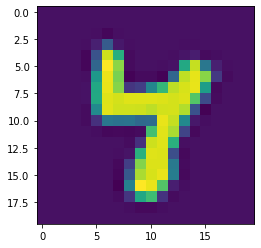


Neural Network Prediction: [4]

Paused - press enter to continue, q to exit:

Displaying Example Image



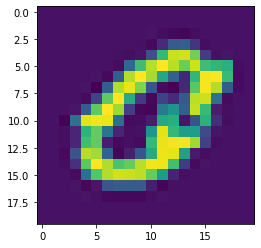


Neural Network Prediction: [10]

Paused - press enter to continue, q to exit:

Displaying Example Image



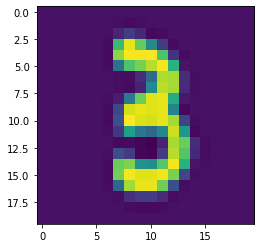


Neural Network Prediction: [3]

Paused - press enter to continue, q to exit:q


In [25]:
# Randomly permute examples
rp = np.random.randint(X.shape[0], size=n);

for i in range(10):
    # Display 
    print('\nDisplaying Example Image\n')
    display_numbers(np.array([X[rp[i], :]]))

    pred = predict(Theta1, Theta2, np.array([X[rp[i], :]]))
    print(f'\nNeural Network Prediction: {pred}\n')
    
    # Pause with quit option
    s = input('Paused - press enter to continue, q to exit:')
    if s == 'q':
        break

<script>
  $(document).ready(function(){
    $('div.prompt').hide();
    $('div.back-to-top').hide();
    $('nav#menubar').hide();
    $('.breadcrumb').hide();
    $('.hidden-print').hide();
  });
</script>

<footer id="attribution" style="float:right; color:#808080; background:#fff;">
Created with Jupyter by Esteban Jiménez Rodríguez. Based on the content of the Machine Learning course offered through coursera by Prof. Andrew Ng.
</footer>